In [1]:
import pandas as pd
import numpy as np
from pymatgen.core.structure import Structure, Site
import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from ase.visualize.plot import plot_atoms
from collections import Counter
import random
import matgl

In [2]:
model = matgl.load_model("M3GNet-MP-2018.6.1-Eform")

d:\Projects\projects_python\energy_of_defects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
struct = Structure.from_file("MoS2.cif")
struct

d:\Projects\projects_python\energy_of_defects\.venv\lib\site-packages\pymatgen\io\cif.py:1285: UserWarning: Issues encountered while parsing CIF: 48 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999997 22.103155538338676 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
    pbc : True True True
PeriodicSite: Mo0 (Mo) (1.276e-07, 1.842, 3.72) [0.04167, 0.08333, 0.25]
PeriodicSite: Mo1 (Mo) (-1.595, 4.605, 3.72) [0.04167, 0.2083, 0.25]
PeriodicSite: Mo2 (Mo) (-3.19, 7.368, 3.72) [0.04167, 0.3333, 0.25]
PeriodicSite: Mo3 (Mo) (-4.785, 10.13, 3.72) [0.04167, 0.4583, 0.25]
PeriodicSite: Mo4 (Mo) (-6.381, 12.89, 3.72) [0.04167, 0.5833, 0.25]
PeriodicSite: Mo5 (Mo) (-7.976, 15.66, 3.72) [0.04167, 0.7083, 0.25]
PeriodicSite: Mo6 (Mo) (-9.571, 18.42, 3.72) [0.04167, 0.8333, 0.25]
PeriodicSite: Mo7 (Mo) (-11.17, 21.18, 3.72) [0.04167, 0.9583, 0.25]
PeriodicSite: Mo8 (Mo) (3.19, 1.842, 3.72) [0.1667, 0.08333, 0.25]
PeriodicSite: Mo9 (Mo) (1.595, 4.605, 3.72) [0.1667, 0.2083, 0.25]
Per

In [4]:
def print_atom_structure2(structure):
    ase_atoms = AseAtomsAdaptor.get_atoms(structure)
    fig, ax = plt.subplots()
    plt.axis('off')
    plt.legend(labels=['Mo', 'S'])
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('14x, 0y, 0z'), show_unit_cell=True)

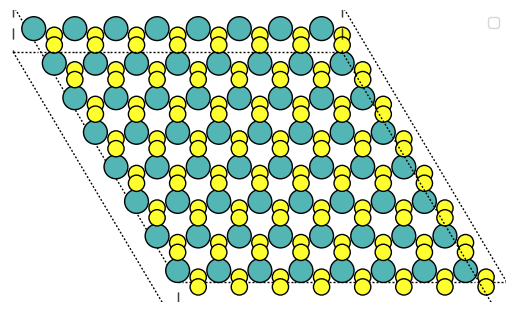

In [5]:
print_atom_structure2(struct)

In [6]:
def predict_energy_of_struct(struct: Structure):
    return model.predict_structure(struct)

In [57]:
def remove_random_atom(structure: Structure, element: str, save_cif = False):
    indices = [i for i, site in enumerate(structure) if site.species_string == element]
    
    if not indices:
        print(f"No atoms of element '{element}' found.")
        return structure
    
    random_index = random.choice(indices)
    
    removed_atom = structure[random_index]
    
    modified_structure = structure.copy()  
    modified_structure.remove_sites([random_index])
    
    if save_cif:
        modified_structure.to(fmt="cif", filename="modified_structure.cif")
    
    return modified_structure, removed_atom

In [58]:
struct_m, removed_atom = remove_random_atom(struct, "Mo")

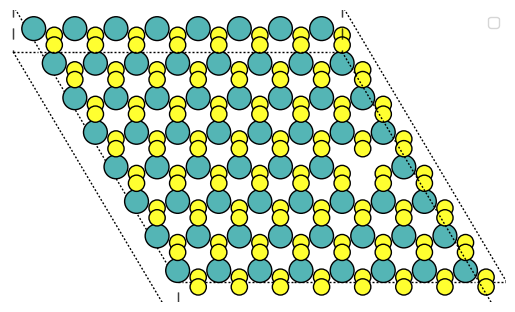

In [59]:
print_atom_structure2(struct_m)

In [60]:
def find_nearest_and_opposite_atom(structure: Structure, removed_atom: Site):
    removed_coords = removed_atom.coords
    removed_species = removed_atom.species_string
    
    neighbors = structure.get_neighbors(removed_atom, r=5.0)

    if not neighbors:
        print("Недостаточно соседей для определения расстояний.")
        return None, None

    neighbor_sites = [neighbor[0] for neighbor in neighbors]  
    filtered_neighbors = [site for site in neighbor_sites if site.species_string == removed_species]
    
    if not filtered_neighbors:
        print("Нет соседей того же типа элемента.")
        return None, None

    neighbor_coords = np.array([site.coords for site in filtered_neighbors])

    distances = np.linalg.norm(neighbor_coords - removed_coords, axis=1)
    nearest_atom_index = np.argmin(distances)
    nearest_atom = filtered_neighbors[nearest_atom_index]

    opposite_distances = np.linalg.norm(neighbor_coords - neighbor_coords[nearest_atom_index], axis=1)

    opposite_distances[nearest_atom_index] = -np.inf  

    opposite_atom_index = np.argmax(opposite_distances)
    opposite_atom = filtered_neighbors[opposite_atom_index]

    return nearest_atom, opposite_atom

In [61]:
nearest_atom, opposite_atom = find_nearest_and_opposite_atom(struct_m, removed_atom)

In [ ]:
def move_atom_towards_midpoint(structure: Structure, atom1: Site, atom2: Site, steps: int = 20) -> list:
    list_of_energy = []
    
    coords1 = atom1.coords
    coords2 = atom2.coords
    # print_atom_structure2(structure)
    
    distance_vector = coords2 - coords1
    
    step_vector = distance_vector / (steps * 2) 

    for step in range(steps):
        coords1 += step_vector
        
        structure[atom1.index].coords = coords1
        
        # для отображения передвижения атома
        # print_atom_structure2(structure)
        list_of_energy.append(predict_energy_of_struct(structure).item())
    
    return list_of_energy


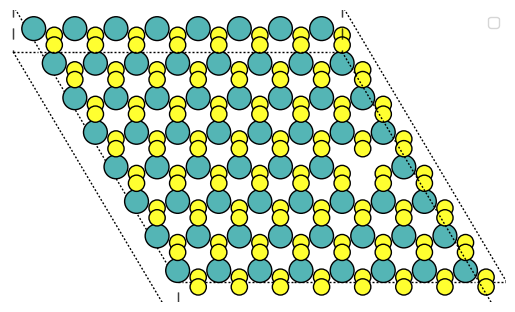

In [63]:
print_atom_structure2(struct_m)

In [93]:
list_of_energy = move_atom_towards_midpoint(struct_m, nearest_atom, opposite_atom)

In [ ]:
def plot_values(values):
    x = list(range(1, len(values) + 1)) 

    plt.figure(figsize=(10, 6))
    plt.plot(x, values, marker='o', color='b', label='Значения')

    plt.title('График изменения энергий')
    plt.xlabel('Итерация')
    plt.ylabel('Энергия')
    plt.xticks(x)  
    plt.grid()
    plt.legend()

    plt.show()

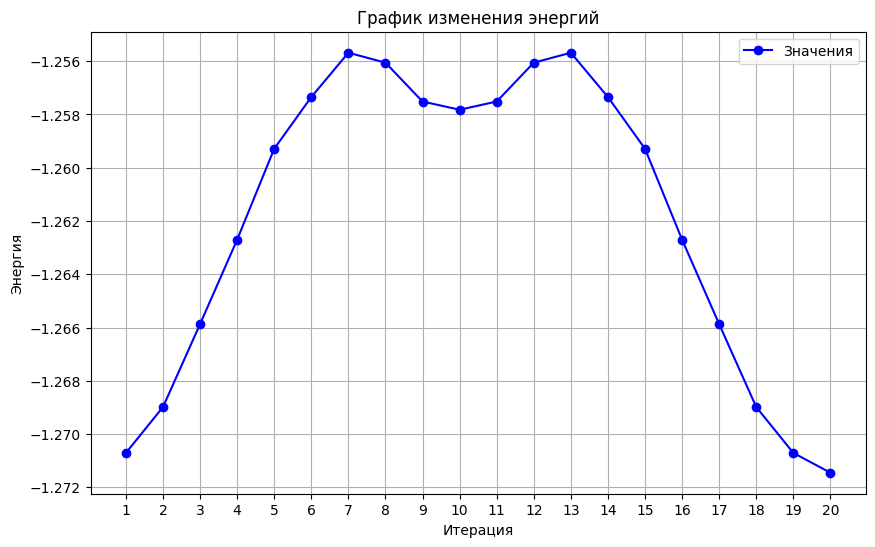

In [99]:
plot_values(list_of_energy)